In [1]:
N_wires = 3
num_wires = N_wires

In [2]:
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
import qiskit
import qiskit.providers.aer.noise as noise
# from pennylane_cirq import ops as cirq_ops

import pennylane as qml
import torch
from torch.autograd.functional import hessian, jacobian
# from pennylane_ionq import ops # not used right now, but for future
from pennylane import numpy as np # autograd compatible numpy
from pennylane.numpy import pi 
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
%precision %0.4f   
#control display precision

if True:    #for collapsing following block in Spyder or any editor
    import seaborn as sns
    
    sns.set_color_codes("deep"); sns.set_context("paper"); sns.set_style("ticks")
    STYLE_DICT = dict.fromkeys(['axes.labelsize', 'xtick.labelsize', 'ytick.labelsize', 'axes.titlesize'], 'medium')
    STYLE_DICT.update({'font.size': 18, 'figure.dpi':150, 'image.cmap': 'plasma'})
    STYLE_DICT.update(dict.fromkeys(['ytick.direction', 'xtick.direction'], 'in'))
    STYLE_DICT.update(dict.fromkeys(['xtick.major.width', 'ytick.major.width', 'axes.linewidth'], .5))
    plt.rcParams.update(STYLE_DICT)

0: ──Rot(0.52,0.43,0.85)─╭●────╭X──Rot(0.07,0.70,0.33)─╭●─╭X──Rot(0.66,0.29,0.23)
1: ──Rot(0.46,0.66,0.86)─╰X─╭●─│───Rot(0.10,0.26,0.83)─│──╰●─╭X──────────────────
2: ──Rot(0.44,0.30,0.54)────╰X─╰●──Rot(0.63,0.84,0.71)─╰X────╰●──────────────────

───────────────────────╭●────╭X─┤  State
───Rot(0.48,0.15,0.61)─╰X─╭●─│──┤  State
───Rot(0.92,0.71,0.61)────╰X─╰●─┤  State
(<Figure size 2250x600 with 1 Axes>, <Axes: >)
tensor([ 0.1842+7.1390e-01j,  0.1473-2.7153e-01j,  0.0227-2.2472e-01j,
        -0.1590+1.1855e-02j,  0.0008+7.3110e-03j, -0.2065+3.0565e-01j,
         0.0345-1.1354e-03j,  0.3837-1.9944e-04j], dtype=torch.complex128)
0: ──Rot(0.52,0.43,0.85)─╭●────╭X──Rot(0.07,0.70,0.33)─╭●─╭X──Rot(0.66,0.29,0.23)
1: ──Rot(0.46,0.66,0.86)─╰X─╭●─│───Rot(0.10,0.26,0.83)─│──╰●─╭X──────────────────
2: ──Rot(0.44,0.30,0.54)────╰X─╰●──Rot(0.63,0.84,0.71)─╰X────╰●──────────────────

───────────────────────╭●────╭X─┤  State
───Rot(0.48,0.15,0.61)─╰X─╭●─│──┤  State
───Rot(0.92,0.71,0.61)────╰X─╰●─┤  St

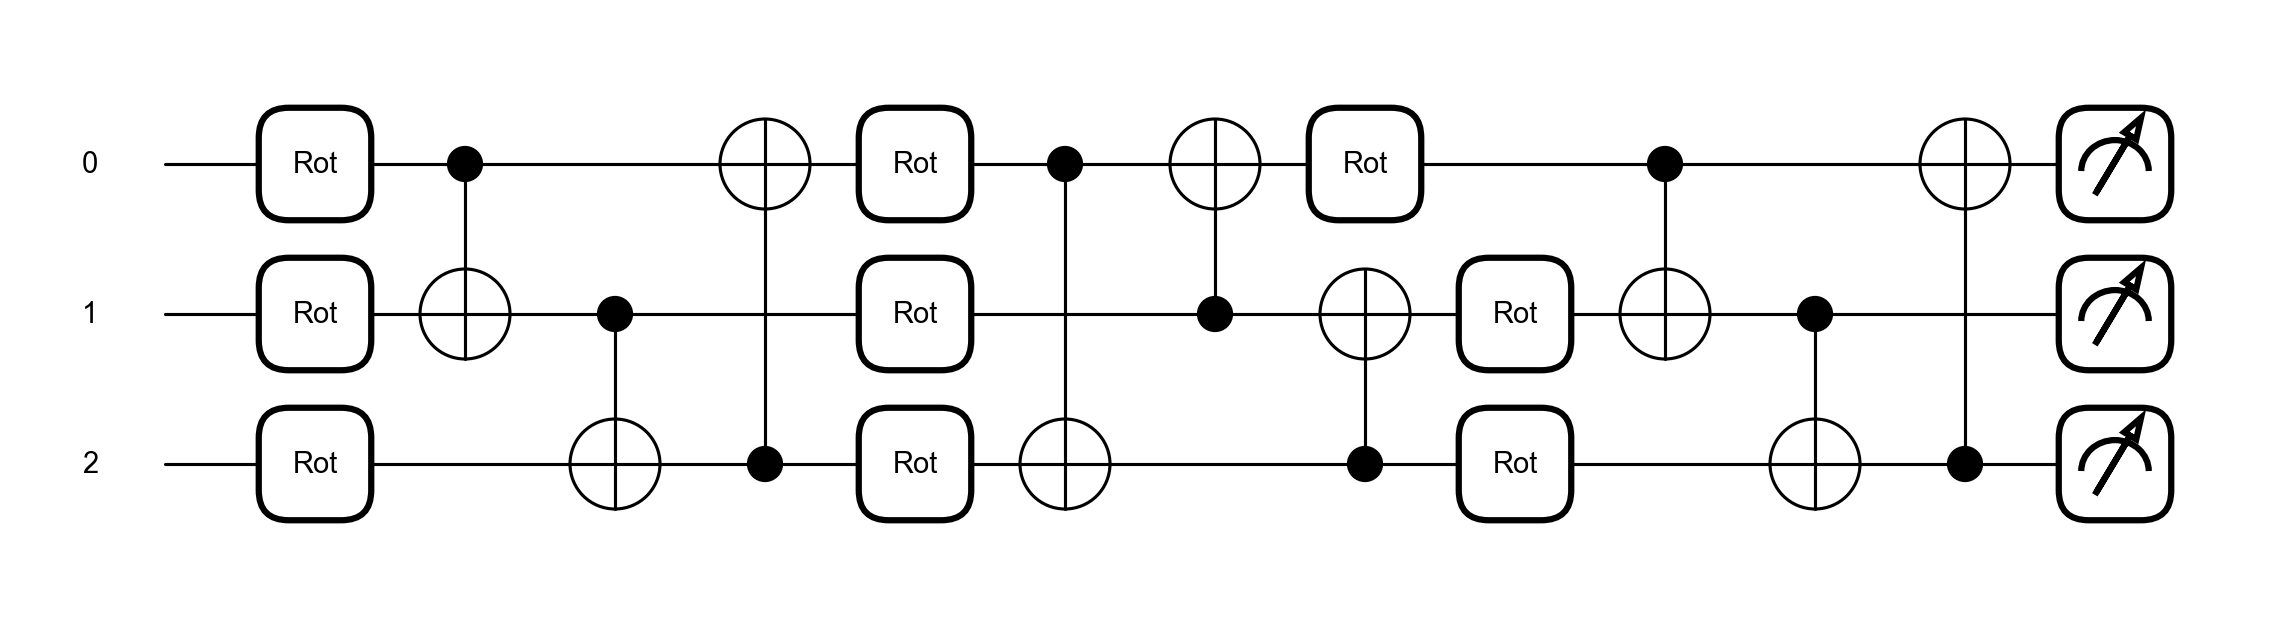

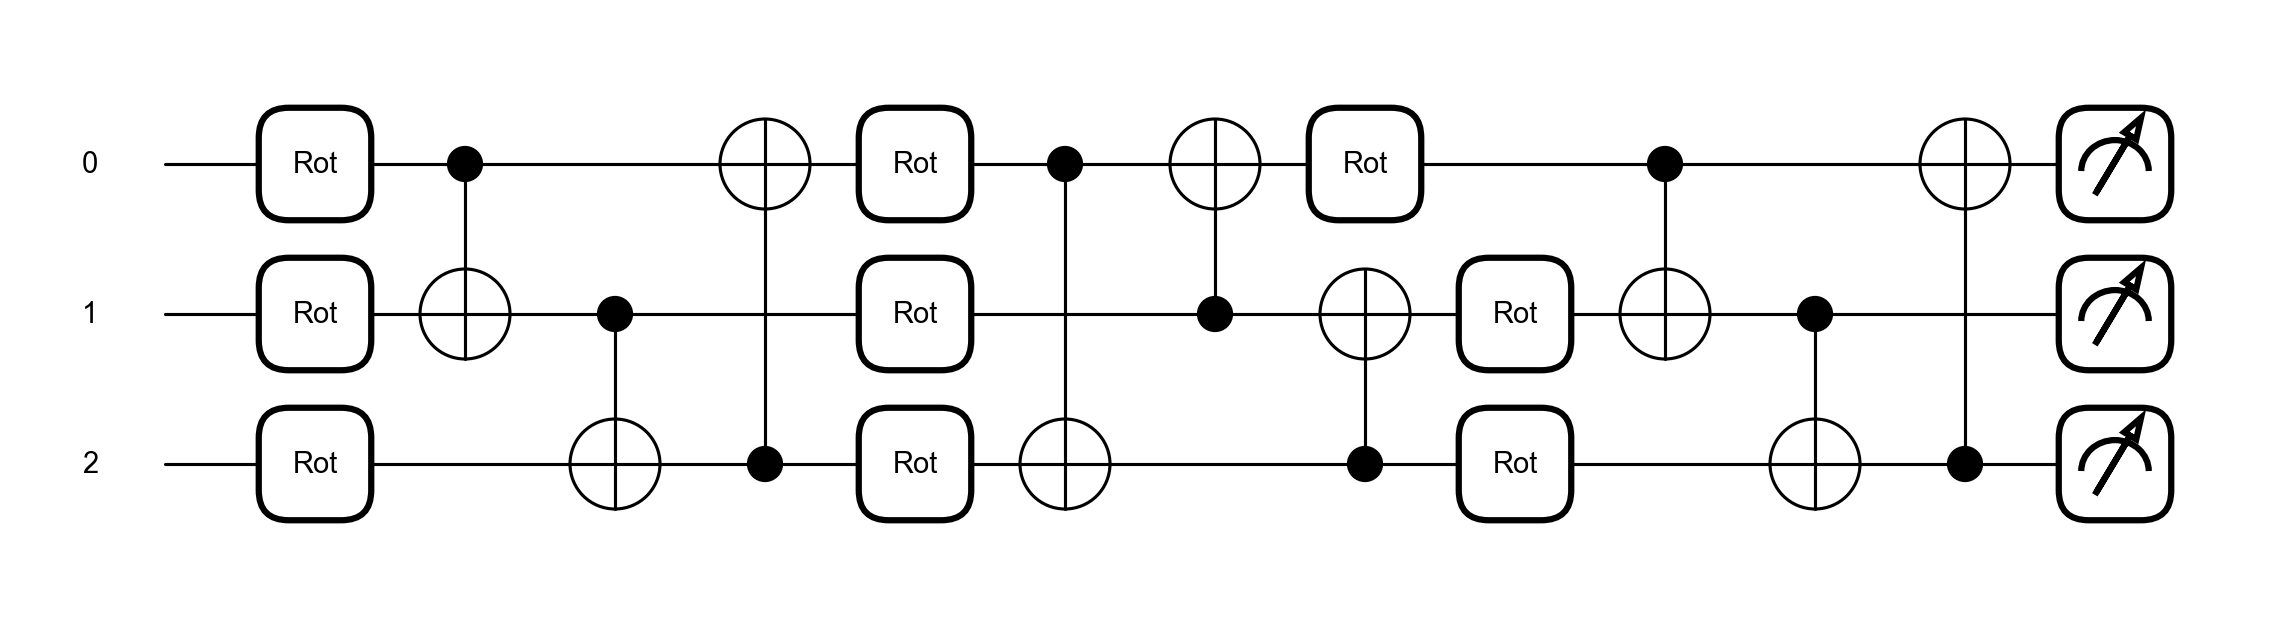

In [ ]:
N_wires = num_wires
param_shape = qml.StronglyEntanglingLayers.shape(n_layers=3, n_wires=N_wires)
weights = torch.rand(param_shape)

dev = qml.device("default.qubit", wires=num_wires)
@qml.qnode(dev, interface='torch', diff_method="backprop")
def circuit_random_layers(parameters, noise_amp=0.00):
    # rnd_gen = np.random.default_rng()
    # rnd_phases = rnd_gen.uniform(-0.5, 0.5, size=(parameters.shape))*noise_amp*2*pi
    rnd_phases = (torch.rand(parameters.shape) - 0.50) * noise_amp*2*pi
    qml.StronglyEntanglingLayers(weights=parameters+rnd_phases, wires=range(N_wires))
    return qml.state()
print(qml.draw(circuit_random_layers, expansion_strategy='device')(weights))
print(qml.draw_mpl(circuit_random_layers, expansion_strategy='device')(weights))
print(circuit_random_layers(weights))

@qml.qnode(dev, interface='torch', diff_method="backprop")
def circuit_random_layers_no_noise(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(N_wires))
    return qml.state()
print(qml.draw(circuit_random_layers_no_noise, expansion_strategy='device')(weights))
print(qml.draw_mpl(circuit_random_layers_no_noise, expansion_strategy='device')(weights))

In [4]:
def fidelity(cur_state, target_state): # Inner product 
    return torch.real(torch.dot(torch.conj(cur_state), target_state))

def norm(state): # normalize 
    return state / torch.sqrt((torch.dot(torch.conj(state), state)))

def phi_parameterization(params): # restrict phase angles to -pi to pi
    return torch.clip(params, -1.5*pi, 1.5*pi) #np is okay since the params input should be a pytorch array



In [5]:
w = torch.exp(torch.tensor((pi*1j)/(2**(num_wires-1)), dtype=torch.complex128))
w1 = w
w2 = w*w
w3 = w*w*w
w4 = w*w*w*w
w5 = w*w*w*w*w
w6 = w*w*w*w*w*w
w7 = w*w*w*w*w*w*w
qft_3 = torch.tensor([[1,1,1,1,1,1,1,1],[1,w1,w2,w3,w4,w5,w6,w7],[1,w2,w4,w6,1,w2,w4,w6],[1,w3,w6,w,w4,w7,w2,w5],
[1,w4,1,w4,1,w4,1,w4],[1,w5,w2,w7,w4,w1,w6,w3],[1,w6,w4,w2,1,w6,w4,w2],[1,w7,w6,w5,w4,w3,w2,w1]], dtype=torch.complex128) / 2**(num_wires/2)

# qft_3 = np.eye(2**num_qubits)
#plt.subplot(121); plt.pcolormesh(qft_3.real)
#plt.subplot(122); plt.pcolormesh(qft_3.angle())
#plt.colorbar()

print(qft_3)

tensor([[ 0.3536+0.0000j,  0.3536+0.0000j,  0.3536+0.0000j,  0.3536+0.0000j,
          0.3536+0.0000j,  0.3536+0.0000j,  0.3536+0.0000j,  0.3536+0.0000j],
        [ 0.3536+0.0000j,  0.2500+0.2500j,  0.0000+0.3536j, -0.2500+0.2500j,
         -0.3536+0.0000j, -0.2500-0.2500j,  0.0000-0.3536j,  0.2500-0.2500j],
        [ 0.3536+0.0000j,  0.0000+0.3536j, -0.3536+0.0000j,  0.0000-0.3536j,
          0.3536+0.0000j,  0.0000+0.3536j, -0.3536+0.0000j,  0.0000-0.3536j],
        [ 0.3536+0.0000j, -0.2500+0.2500j,  0.0000-0.3536j,  0.2500+0.2500j,
         -0.3536+0.0000j,  0.2500-0.2500j,  0.0000+0.3536j, -0.2500-0.2500j],
        [ 0.3536+0.0000j, -0.3536+0.0000j,  0.3536+0.0000j, -0.3536+0.0000j,
          0.3536+0.0000j, -0.3536+0.0000j,  0.3536+0.0000j, -0.3536+0.0000j],
        [ 0.3536+0.0000j, -0.2500-0.2500j,  0.0000+0.3536j,  0.2500-0.2500j,
         -0.3536+0.0000j,  0.2500+0.2500j,  0.0000-0.3536j, -0.2500+0.2500j],
        [ 0.3536+0.0000j,  0.0000-0.3536j, -0.3536+0.0000j,  0.0000+0.

In [6]:
#circuit unitary
dev2 = qml.device("default.qubit", wires=num_wires)

# @qml.qnode(dev, interface='torch', diff_method="backprop")
def unitary_random_layers_no_noise(array):
    return qml.StronglyEntanglingLayers(weights=phi_parameterization(array.reshape(param_shape)), wires=range(N_wires))

def unitary_result(array):
    # op = unitary_random_layers_no_noise(array)
    # matrix = qml.matrix(op)
    # matrix_torch = torch.tensor(matrix, dtype=torch.complex128, requires_grad=True)
    matrix_torch = qml.matrix(qml.StronglyEntanglingLayers(weights=phi_parameterization(array.reshape(param_shape)), wires=range(N_wires)))
    return matrix_torch

#fidelity between target matrix and unitary
def matrix_fidelity(mat1, mat2):
    squared = mod_squared(torch.sub(mat1, mat2))
    summed = torch.sum(squared)
    #float_val = extract_float(summed)
    return summed

#helper functions
def mod_squared(mat):
    if mat.dtype == torch.complex64 or mat.dtype == torch.complex128:
        real_part = mat.real
        imag_part = mat.imag    
        # return torch.tensor(torch.pow(real_part, 2) + torch.pow(imag_part, 2))
        return real_part**2 + imag_part**2
    else:
        # return torch.pow(mat, 2)
        return mat**2

def extract_float(tensor):
    if tensor.numel() == 1:
        float_value = tensor.item()
        return float_value

In [8]:
ghz_list = [1] + [0.0]*(2**N_wires) + [-1] # GHZ state
w_list = [0]*(2**N_wires); 
for ii in range(N_wires):
    w_list[2**ii] = 1; #1/torch.sqrt(N_wires) # W state
target_state = qft_3 #norm(torch.tensor(w_list, dtype=torch.complex128)) # W state
Nshots = 4 # Number of shots each with a diff initial phase angles
steps = 64*2 # Number of steps per shot
eta = 0.09 # learning rate
phi_len = torch.prod(torch.tensor(param_shape))
I = torch.eye(phi_len, requires_grad=False); delta = 1.50; alpha = 5*eta
# random_seeds = range(101, 25000, 33) # construct a large array of seeds > Nshots in length
random_seeds = range(14, 25000, 35) # construct a large array of seeds > Nshots in length

phi_arr_best = torch.zeros(phi_len, requires_grad=False)
costs_final = 1
cost_history_best = []
noise_amplitude = 0.000

def cost_fn_no_noise(phi_arr): # define local cost function with only parameters as phase angles
    return matrix_fidelity(unitary_result(phi_arr), qft_3)

def cost_fn_noisy(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers(phi_parameterization(phi_arr.reshape(param_shape)), noise_amp=noise_amplitude), target_state)


for ii in range (Nshots):
    #print(f"\nEpoch {ii}")
    torch.manual_seed(random_seeds[ii])
    phi_arr0 = torch.randn(phi_len, requires_grad=True)
    phi_arr = phi_arr0
    K = torch.zeros((phi_len, phi_len), requires_grad=False)
    cost_history = []

    optimizer = torch.optim.Adam([phi_arr], lr=eta*1.5)
    #optimizer = torch.optim.LBFGS([phi_arr], lr=eta/3, tolerance_change=1e-13, tolerance_grad=1e-13)
    def closure():
        # print("Cost Func Value: ", cost_fn_no_noise(phi_arr))
        optimizer.zero_grad()
        loss = cost_fn_no_noise(phi_arr)
        # print("Loss: ", loss)
        loss.backward()
        return loss

    for jj in range(steps):
        optimizer.step(closure)
        cost = cost_fn_no_noise(phi_arr)
        # -------- Following lines for IPG----------
    # for jj in range(steps):
    #     hess = hessian(cost_fn_noisy, phi_arr)
    #     K = K   -   alpha * (torch.matmul(hess, K) - I)
    #     g = jacobian(cost_fn_noisy, phi_arr)
    #     phi_arr = phi_arr - delta*torch.matmul(K, g)
    #     cost = cost_fn_noisy(phi_arr)
        #--------Above lines for IPG---------------

        # Next line is for running built-in optimizers like GD, Adam, Nesterov
        # phi_arr, cost = opt.step_and_cost(cost_fn_noisy, phi_arr, grad_fn=grad_fn)
        if (jj+1) % (steps//5) == 0 or jj==steps-1:
            print(f"Step {jj+1:3d}\t Cost_L = {cost:0.7f}")
        cost_history.append(cost.clone().detach())
    if ii == 0:
        Adam_iteration0 = np.copy(cost_history)
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
    if ii == 1:
        Adam_iteration1 = np.copy(cost_history)
    if ii == 2:
        Adam_iteration2 = np.copy(cost_history)
    if ii == 3:
        Adam_iteration3 = np.copy(cost_history)
    if costs_final > cost_history[-1]:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
print(f"Best cost out of {Nshots} attempts: {np.mean(cost_history_best[steps*9//10:])}") # For noisy final costs, take a mean over last 10% of costs
print(f"Optimized phases (in $\pi$ units): {phi_arr_best/pi}")
torch.save(cost_history_best, f"costs_ADAM_delta{delta}_alpha{alpha}.pt")

Adam_best_cost_history = np.copy(cost_history_best)
Adam_phi_arr_best = np.copy(phi_arr_best)

Step  25	 Cost_L = 5.1459729
Step  50	 Cost_L = 4.3808260
Step  75	 Cost_L = 4.1351710
Step 100	 Cost_L = 3.7816255
Step 125	 Cost_L = 3.7734015
Step 128	 Cost_L = 3.7718090
Step  25	 Cost_L = 8.2173224
Step  50	 Cost_L = 5.8030603
Step  75	 Cost_L = 5.5829202
Step 100	 Cost_L = 5.5659736
Step 125	 Cost_L = 5.5647535
Step 128	 Cost_L = 5.5647527
Step  25	 Cost_L = 3.1586994
Step  50	 Cost_L = 1.8704562
Step  75	 Cost_L = 1.7878424
Step 100	 Cost_L = 1.7809809
Step 125	 Cost_L = 1.7805840
Step 128	 Cost_L = 1.7805720
Step  25	 Cost_L = 6.6394725
Step  50	 Cost_L = 5.7272261
Step  75	 Cost_L = 5.6889981
Step 100	 Cost_L = 5.6842124
Step 125	 Cost_L = 5.6837145
Step 128	 Cost_L = 5.6837206
Best cost out of 4 attempts: 1.7805969261323977
Optimized phases (in $\pi$ units): tensor([-5.0026e-01,  1.2457e-01, -1.0002e+00, -2.4954e-01, -2.5040e-01,
         4.9950e-01,  8.7463e-01,  4.9966e-01, -4.1090e-06,  5.0012e-01,
         4.9986e-01,  5.0018e-01, -5.0111e-01, -2.5025e-01,  5.0110e-01,
  

In [9]:
ghz_list = [1] + [0.0]*(2**N_wires) + [-1] # GHZ state
w_list = [0]*(2**N_wires); 
for ii in range(N_wires):
    w_list[2**ii] = 1; #1/torch.sqrt(N_wires) # W state
target_state = qft_3 #norm(torch.tensor(w_list, dtype=torch.complex128)) # W state
Nshots = 4 # Number of shots each with a diff initial phase angles
steps = 64*2 # Number of steps per shot
eta = 0.09 # learning rate
phi_len = torch.prod(torch.tensor(param_shape))
I = torch.eye(phi_len, requires_grad=False); delta = 1.00; alpha = 1*eta
# random_seeds = range(101, 25000, 33) # construct a large array of seeds > Nshots in length
random_seeds = range(14, 25000, 35) # construct a large array of seeds > Nshots in length

phi_arr_best = torch.zeros(phi_len, requires_grad=False)
costs_final = 1
cost_history_best = []
noise_amplitude = 0.000

def cost_fn_no_noise(phi_arr): # define local cost function with only parameters as phase angles
    return matrix_fidelity(unitary_result(phi_arr), qft_3)

def cost_fn_noisy(phi_arr): # define local cost function with only parameters as phase angles
    return 1. - \
        fidelity(circuit_random_layers(phi_parameterization(phi_arr.reshape(param_shape)), noise_amp=noise_amplitude), target_state)


for ii in range (Nshots):
    #print(f"\nEpoch {ii}")
    torch.manual_seed(random_seeds[ii])
    phi_arr0 = torch.randn(phi_len, requires_grad=True)
    phi_arr = phi_arr0
    K = torch.zeros((phi_len, phi_len), requires_grad=False)
    cost_history = []

    optimizer = torch.optim.Adam([phi_arr], lr=eta*1.5)
    # optimizer = torch.optim.LBFGS([phi_arr], lr=eta/3, tolerance_change=1e-13, tolerance_grad=1e-13)
    def closure():
        # print("Cost Func Value: ", cost_fn_no_noise(phi_arr))
        optimizer.zero_grad()
        loss = cost_fn_no_noise(phi_arr)
        # print("Loss: ", loss)
        loss.backward()
        return loss

    # for jj in range(steps):
    #     optimizer.step(closure)
    #     cost = cost_fn_no_noise(phi_arr)
        # -------- Following lines for IPG----------
    for jj in range(steps):
        hess = hessian(cost_fn_no_noise, phi_arr)
        K = K   -   alpha * (torch.matmul(hess, K) - I)
        g = jacobian(cost_fn_no_noise, phi_arr)
        phi_arr = phi_arr - delta*torch.matmul(K, g)
        cost = cost_fn_no_noise(phi_arr)
        #--------Above lines for IPG---------------

        # Next line is for running built-in optimizers like GD, Adam, Nesterov
        # phi_arr, cost = opt.step_and_cost(cost_fn_noisy, phi_arr, grad_fn=grad_fn)
        if (jj+1) % (steps//5) == 0 or jj==steps-1:
            print(f"Step {jj+1:3d}\t Cost_L = {cost:0.7f}")
        cost_history.append(cost.clone().detach())
    if ii == 0:
        IPG_iteration_0 = np.copy(cost_history)
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
    if ii == 1:
        IPG_iteration1 = np.copy(cost_history)
    if ii == 2:
        IPG_iteration2 = np.copy(cost_history)
    if ii == 3:
        IPG_iteration3 = np.copy(cost_history)
    if costs_final > cost_history[-1]:
        costs_final = cost_history[-1]
        cost_history_best = np.copy(cost_history)
        phi_arr_best = phi_arr.clone().detach()
print(f"Best cost out of {Nshots} attempts: {np.mean(cost_history_best[steps*9//10:])}") # For noisy final costs, take a mean over last 10% of costs
print(f"Optimized phases (in $\pi$ units): {phi_arr_best/pi}")
torch.save(cost_history_best, f"costs_IPG_delta{delta}_alpha{alpha}.pt")

IPG_best_cost_history = np.copy(cost_history_best)
IPG_phi_arr_best = np.copy(phi_arr_best)

Step  25	 Cost_L = 4.3067012
Step  50	 Cost_L = 3.2878393
Step  75	 Cost_L = 3.2716337
Step 100	 Cost_L = 3.2716339
Step 125	 Cost_L = 3.2716342
Step 128	 Cost_L = 3.2716337
Step  25	 Cost_L = 3.2716883
Step  50	 Cost_L = 3.2716340
Step  75	 Cost_L = 3.2716337
Step 100	 Cost_L = 3.2716339
Step 125	 Cost_L = 3.2716340
Step 128	 Cost_L = 3.2716339
Step  25	 Cost_L = 4.8287630
Step  50	 Cost_L = 4.7607755


KeyboardInterrupt: 

In [ ]:
#circuit unitary
#@qml.qnode(dev, interface='torch', diff_method="backprop")
def unitary_random_layers_no_noise(array):
    return qml.StronglyEntanglingLayers(weights=phi_parameterization(array.reshape(param_shape)), wires=range(N_wires))

def unitary_result(array):
    op = unitary_random_layers_no_noise(array)
    matrix = qml.matrix(op)
    matrix_torch = torch.tensor(matrix, dtype=torch.complex128, requires_grad=True)
    return matrix_torch

#fidelity between target matrix and unitary
def matrix_fidelity(mat1, mat2):
    squared = mod_squared(torch.sub(mat1, mat2))
    summed = torch.sum(squared)
    #float_val = extract_float(summed)
    return summed

#helper functions
def mod_squared(mat):
    if mat.dtype == torch.complex64 or mat.dtype == torch.complex128:
        real_part = mat.real
        imag_part = mat.imag    
        return torch.tensor(torch.pow(real_part, 2) + torch.pow(imag_part, 2))
    else:
        return torch.pow(mat, 2)

def extract_float(tensor):
    if tensor.numel() == 1:
        float_value = tensor.item()
        return float_value

In [ ]:
#unitary_result(phi_arr_best)
#matrix_fidelity(unitary_result(phi_arr_best), qft_3)

In [ ]:
#circuit_random_layers_no_noise(phi_parameterization(phi_arr.reshape(param_shape)))

In [ ]:
def inner_product(vector1, vector2): #for column vectors
    return torch.matmul(torch.conj(vector1.T), vector2).item()

def random_state(N_qubits):
    entries = 2**N_qubits
    rand_column = torch.rand(entries, 1, dtype=torch.complex128)
    norm_factor = torch.sum(torch.abs(rand_column)**2)
    normalized_rand_column = rand_column/torch.sqrt(norm_factor)
    return normalized_rand_column

def get_circuit_matrix(phi_array): #this is for NON gradient purposes
    circuit = torch.tensor(unitary_result(phi_array).clone().detach(), dtype=torch.complex128)
    return circuit

def get_statevector(matrix, column_vector):
    result = torch.matmul(matrix, column_vector)
    return result

In [ ]:
#rand_state = random_state(3)
#state1 = get_statevector(qft_3, rand_state)
#state2 = get_statevector(get_circuit_matrix(phi_arr_best), rand_state)

#inner_product(state1, state2)

In [ ]:
IPG_values = []
Adam_values = []
LBFGS_values = []

for i in range(1000):
    rand_state = random_state(3)
    qft_state = get_statevector(qft_3, rand_state)

    IPG_state = get_statevector(get_circuit_matrix(torch.tensor(IPG_phi_arr_best).clone().detach()), rand_state)
    Adam_state = get_statevector(get_circuit_matrix(torch.tensor(Adam_phi_arr_best).clone().detach()), rand_state)
    LBFGS_state = get_statevector(get_circuit_matrix(torch.tensor(LBFGS_phi_arr_best).clone().detach()), rand_state)

    IPG_values.append(inner_product(qft_state, IPG_state))
    Adam_values.append(inner_product(qft_state, Adam_state))
    LBFGS_values.append(inner_product(qft_state, LBFGS_state))

real_IPG = [ele.real for ele in IPG_values]
imag_IPG = [ele.imag for ele in IPG_values]

real_Adam = [ele.real for ele in Adam_values]
imag_Adam = [ele.imag for ele in Adam_values]

real_LBFGS = [ele.real for ele in LBFGS_values]
imag_LBFGS = [ele.imag for ele in LBFGS_values]

/var/folders/db/jnp48mgd6tl_t7mjdywllp940000gn/T/ipykernel_88703/3786429681.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix_torch = torch.tensor(matrix, dtype=torch.complex128, requires_grad=True)
/var/folders/db/jnp48mgd6tl_t7mjdywllp940000gn/T/ipykernel_88703/2335886858.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  circuit = torch.tensor(unitary_result(phi_array).clone().detach(), dtype=torch.complex128)


In [ ]:
if True:    #for collapsing following block in Spyder or any editor
    import seaborn as sns
    
    sns.set_color_codes("deep"); sns.set_context("paper"); sns.set_style("ticks")
    STYLE_DICT = dict.fromkeys(['axes.labelsize', 'xtick.labelsize', 'ytick.labelsize', 'axes.titlesize'], 'medium')
    STYLE_DICT.update({'font.size': 18, 'figure.dpi':150, 'image.cmap': 'plasma'})
    STYLE_DICT.update(dict.fromkeys(['ytick.direction', 'xtick.direction'], 'in'))
    STYLE_DICT.update(dict.fromkeys(['xtick.major.width', 'ytick.major.width', 'axes.linewidth'], .5))
    plt.rcParams.update(STYLE_DICT)

[0.980863194755231, 0.98092811143903, 0.9810552580664235, 0.9806490463912859, 0.9806489360374938, 0.9808327806467798, 0.9808843401530958, 0.9807430676542568, 0.9806718255016195, 0.9808996959911074, 0.9808971208178874, 0.9808769200578072, 0.9809004911522576, 0.9806166107631233, 0.9805436637114646, 0.9810184117129559, 0.9808653451723391, 0.9807306190735269, 0.9806344312213656, 0.9810417584580571, 0.9806120047969048, 0.980741094570049, 0.9811225494268558, 0.9806396964091461, 0.9808331041730298, 0.9808314581844967, 0.9810301490965212, 0.9808751706488839, 0.9808691379950523, 0.980761815427004, 0.9807415593924874, 0.9809658142116428, 0.9807270090510679, 0.9807570378049482, 0.9808161644361383, 0.980755042406401, 0.9807970263665127, 0.980749473288447, 0.9808671638111905, 0.9809501113632532, 0.9807056104576721, 0.9805579259880268, 0.9805692994497092, 0.9808165235225982, 0.9808362738151797, 0.9809423366514489, 0.9806485201003028, 0.9807441114978572, 0.9806452538524489, 0.9807776608345095, 0.9807

<AxesSubplot:title={'center':'IPG/Adam/LBFGS'}, xlabel='Fidelity', ylabel='Counts'>

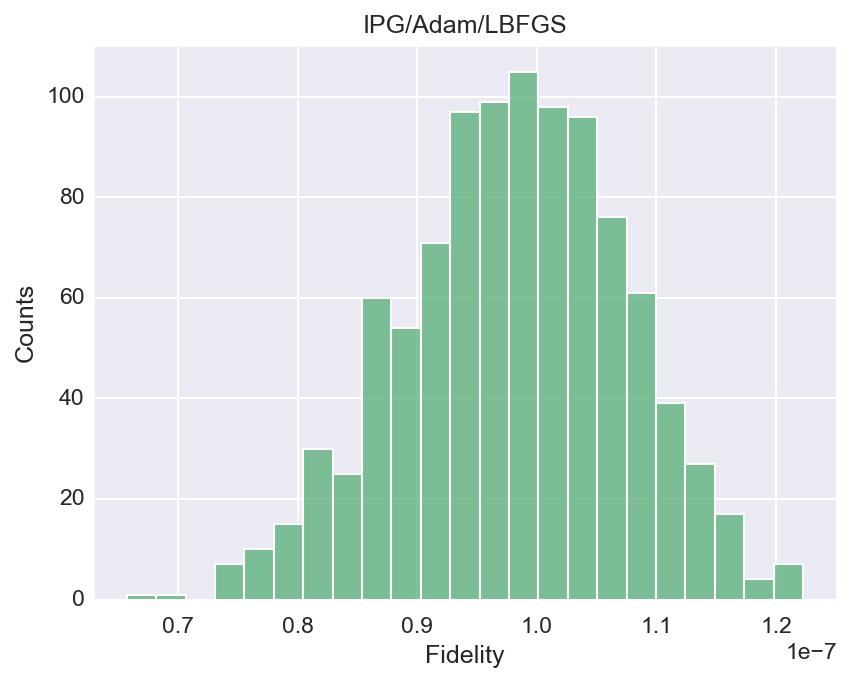

In [ ]:
sns.set_theme()
#sns.color_palette()
plt.xlabel("Fidelity")
plt.ylabel("Counts")
plt.title("IPG/Adam/LBFGS")
#absolute value of amplitude instead
#plt.hist(np.abs(real_Adam), color="#CF102D")
print(real_Adam)
plt.yticks(va='center')
plt.xticks(va='center')
plt.tick_params(axis='y', pad=-2)
plt.tick_params(axis='x', pad=7)
for i in real_Adam:
    if i < 0:
        print()
sns.histplot(1 - np.sqrt(np.abs(IPG_values)), color="#55ad74")

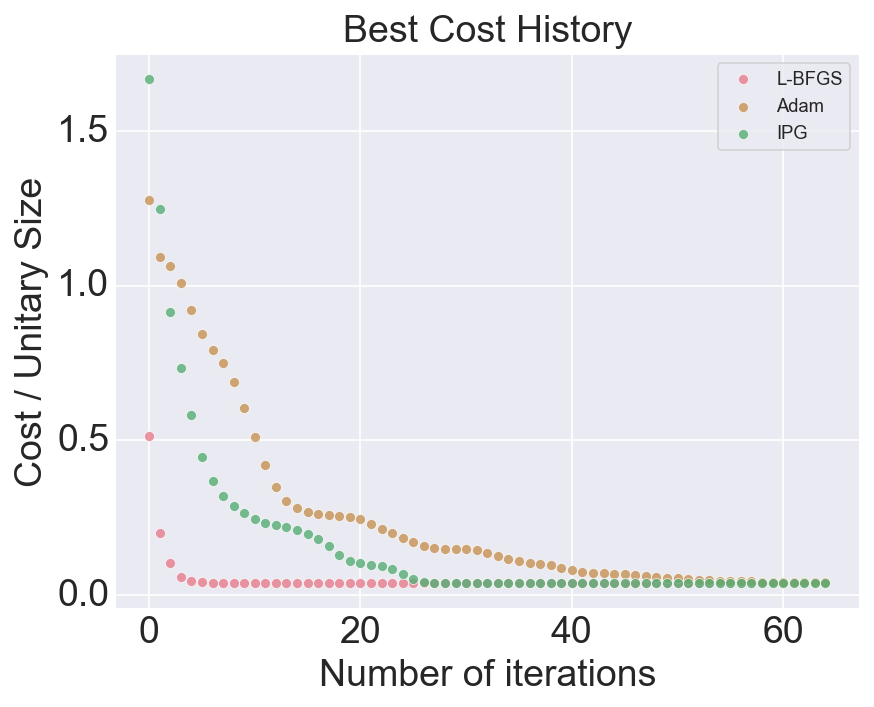

In [ ]:
%matplotlib inline
plt.xlabel("Number of iterations")
plt.ylabel("Cost / Unitary Size")
plt.title("Best Cost History")

limit=65
limit_IPG = []
limit_Adam = []
limit_LBFGS = []

for i in range(limit):
    limit_IPG.append(IPG_best_cost_history[i]/(2**3))
    limit_Adam.append(Adam_best_cost_history[i]/(2**3))
    limit_LBFGS.append(LBFGS_best_cost_history[i]/(2**3))
plt.yticks(va='center')
plt.xticks(va='center')
plt.tick_params(axis='y', pad=-2)
plt.tick_params(axis='x', pad=7)
sns.set_style("darkgrid")
sns.scatterplot(x=[i for i in range(0, limit)], y=limit_LBFGS, label="L-BFGS", color="#e77c8d", alpha=0.8)
sns.scatterplot(x=[i for i in range(0, limit)], y=limit_Adam, label="Adam", color="#c69254", alpha=0.8)
sns.scatterplot(x=[i for i in range(0, limit)], y=limit_IPG, label="IPG", color="#56ad74", alpha=0.8)
plt.gca().invert_yaxis()

In [ ]:
average_IPG = (IPG_iteration_0+IPG_iteration1+IPG_iteration2+IPG_iteration3)/4
average_Adam = (Adam_iteration0+Adam_iteration1+Adam_iteration2+Adam_iteration3)/4
average_LBFGS = (LBFGS_iteration0+LBFGS_iteration1+LBFGS_iteration2+LBFGS_iteration3)/4

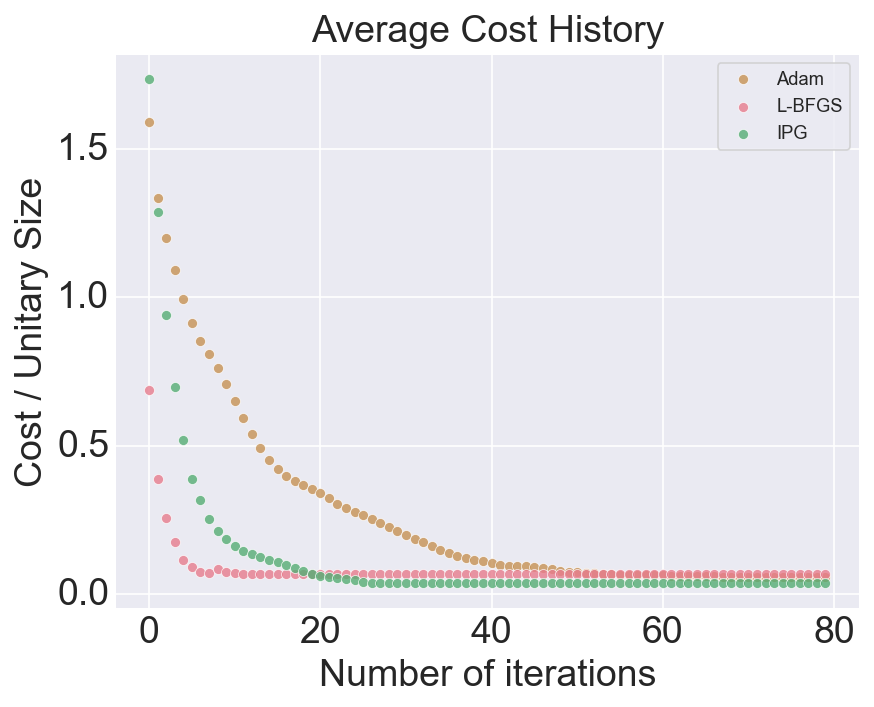

In [ ]:
plt.xlabel("Number of iterations")
plt.ylabel("Cost / Unitary Size")
plt.title("Average Cost History")
sns.set_style("darkgrid")

limit=80
limit_avg_IPG = []
limit_avg_Adam = []
limit_avg_LBFGS = []
for i in range(limit):
    limit_avg_IPG.append(average_IPG[i]/(2**3))
    limit_avg_Adam.append(average_Adam[i]/(2**3))
    limit_avg_LBFGS.append(average_LBFGS[i]/(2**3))
plt.yticks(va='center')
plt.xticks(va='center')
plt.tick_params(axis='y', pad=-2)
plt.tick_params(axis='x', pad=7)
sns.scatterplot(x=[i for i in range(0, limit)], y=limit_avg_Adam, label="Adam", color="#c69254", alpha=0.8)
sns.scatterplot(x=[i for i in range(0, limit)], y=limit_avg_LBFGS, label="L-BFGS", color="#e77c8d", alpha=0.8)
sns.scatterplot(x=[i for i in range(0, limit)], y=limit_avg_IPG, label="IPG", color="#56ad74", alpha=0.8)



plt.gca().invert_yaxis()

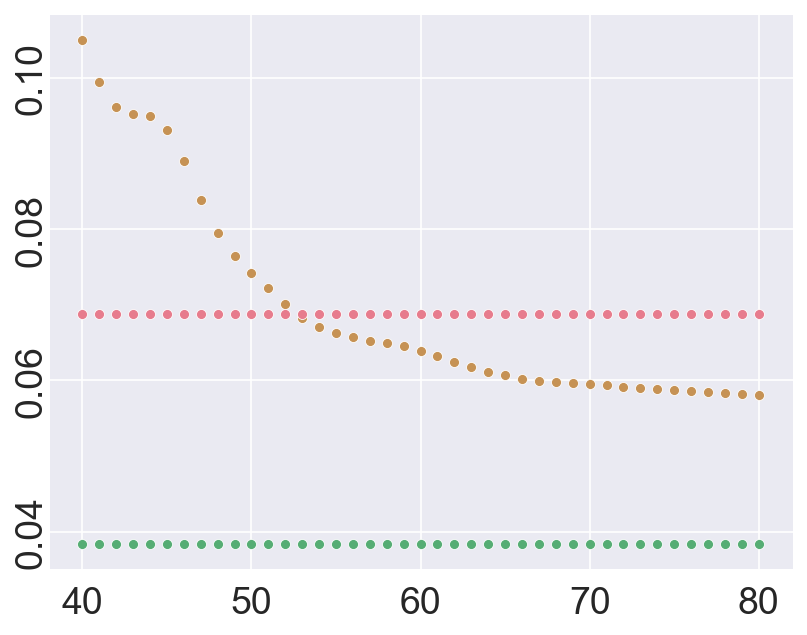

In [ ]:
sns.set_style("darkgrid")
limit=80
limit_avg_IPG = []
limit_avg_Adam = []
limit_avg_LBFGS = []

for i in range(40,81):
    limit_avg_IPG.append(average_IPG[i]/(2**3))
    limit_avg_Adam.append(average_Adam[i]/(2**3))
    limit_avg_LBFGS.append(average_LBFGS[i]/(2**3))

plt.yticks(rotation='vertical', va='center')
plt.tick_params(axis='y', pad=-5)
sns.scatterplot(x=[i for i in range(40, 81)], y=limit_avg_IPG, color="#56ad74")
sns.scatterplot(x=[i for i in range(40, 81)], y=limit_avg_Adam, color="#c69254")
sns.scatterplot(x=[i for i in range(40, 81)], y=limit_avg_LBFGS, color="#e77c8d")
plt.gca().invert_yaxis()